In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
import json
from os import listdir
from os.path import isfile, join, basename, normpath

import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
import tensorflow as tf
from tqdm import tqdm_notebook

from model import zsc
from preprocessing import pad_image

In [3]:
# Parameters
# Architecture
# ZSC
architecture_conv = [
    {"n_conv": 1, "n_kernels": 16},
    {"n_conv": 1, "n_kernels": 32},
    {"n_conv": 1, "n_kernels": 64},
    {"n_conv": 1, "n_kernels": 128},
    {"n_conv": 1, "n_kernels": 128}
]
architecture_fc = [
    {"in_size": 6272, "fc_dim": 512},
    {"in_size": 512, "fc_dim": 512}
]

In [4]:
# Parameters
# Saving
save_path = "models"

In [5]:
x = tf.placeholder(tf.float32, shape=[None, 224, 224, 3])
y = zsc(x, architecture_conv, architecture_fc)

In [6]:
# Start session
sess = tf.InteractiveSession()
init_op = tf.group(
    tf.global_variables_initializer(),
    tf.local_variables_initializer())
sess.run(init_op)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

In [8]:
# Restoring
saver = tf.train.Saver()
model_name = "vgg_fine_tuned-35"
saving_path = join(save_path, model_name)
saver.restore(sess, saving_path)

INFO:tensorflow:Restoring parameters from models/vgg_fine_tuned-35


In [9]:
main_directory = "data"
target_directory = "residential"
target_directory = join(main_directory, target_directory)

In [10]:
infered_positives = list()

In [ ]:
# For whole image lookup
for f in tqdm_notebook(listdir(target_directory)):
    if isfile(join(target_directory, f)) and f.split(".")[-1] == "jpg":
        image_path = join(target_directory, f)
        image = misc.imread(image_path)
        padded_image = pad_image(image)
        y_value = sess.run(y, feed_dict={x: [padded_image]})
        y_value = np.argmax(y_value)
        if y_value == 1:
            infered_positives.append(image_path)

In [11]:
# With region proposal
strides = [0, 144, 288]
region_shape = [224, 224]
for f in tqdm_notebook(listdir(target_directory)):
    if isfile(join(target_directory, f)) and f.split(".")[-1] == "jpg":
        image_path = join(target_directory, f)
        image = misc.imread(image_path)
        y_max = 0
        pos_max = (-1, -1)
        for i_vert, vert_stride in enumerate(strides):
            for i_hor, hor_stride in enumerate(strides):
                region = image[
                    vert_stride:vert_stride + region_shape[0],
                    hor_stride:hor_stride + region_shape[1],
                    :
                ]
                y_value = sess.run(y, feed_dict={x: [region]})
                y_value = y_value[0, 1]
                if y_value > y_max:
                    y_max = y_value
                    pos_max = (i_vert, i_hor)
        if y_max > 0.5:
            infered_positives.append({"im_path": image_path, "pos_in_image": pos_max})

HBox(children=(IntProgress(value=0, max=965), HTML(value='')))

In [12]:
with open("infered_positives.json", "w") as out:
    json.dump(infered_positives, out)

# Positioning

In [13]:
len(infered_positives)

23

In [14]:
with open("infered_positives.json") as in_file:
    infered_positives = json.load(in_file)

In [15]:
for positive in infered_positives:
    im_path = positive["im_path"]
    tile_name = basename(normpath(im_path))
    tile_name = tile_name.split(".")[0]
    pano_name = tile_name.split("_zoom_")[0]
    meta_file_name = "{}_meta.json".format(pano_name)
    meta_file_path = join(target_directory, meta_file_name)
    with open(meta_file_path) as in_file:
        pano_info = json.load(in_file)
    location = pano_info["Location"]
    for coord in ["lat", "lng"]:
        positive[coord] = location[coord]

/home/zaccharie/workspace/interviews/spotangels/signs-challenge/venv/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


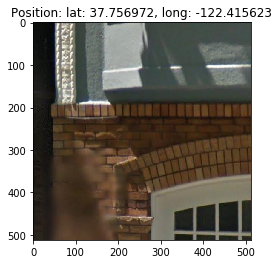

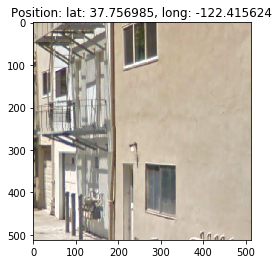

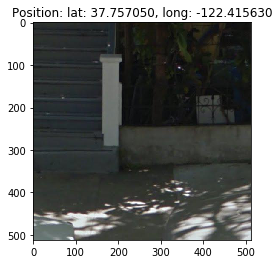

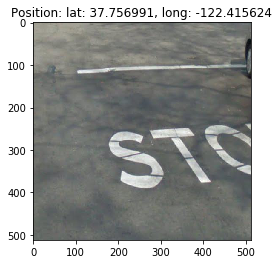

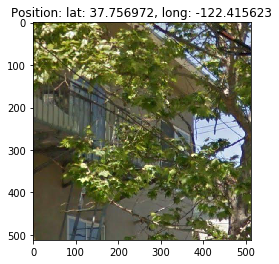

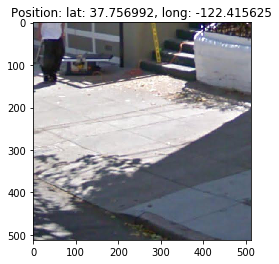

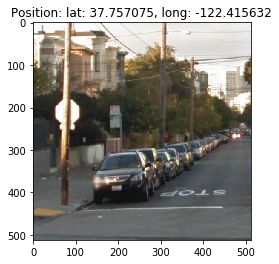

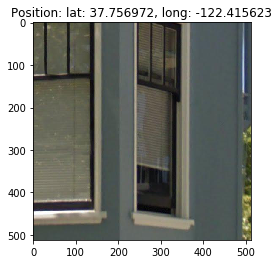

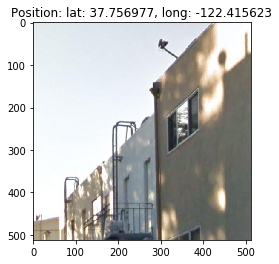

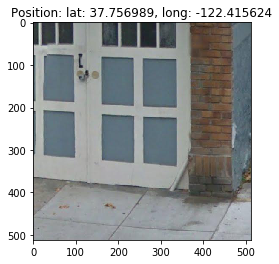

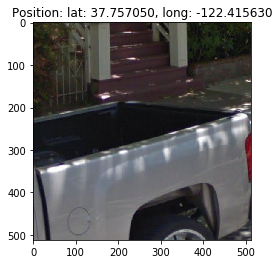

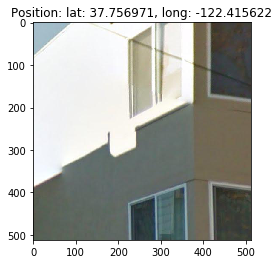

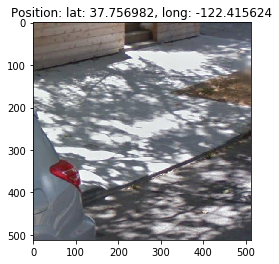

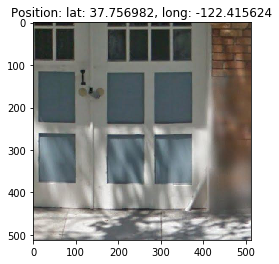

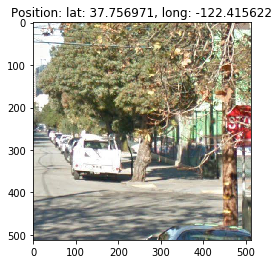

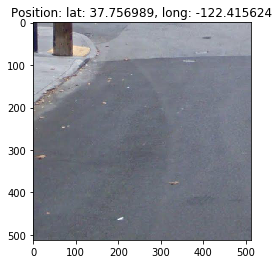

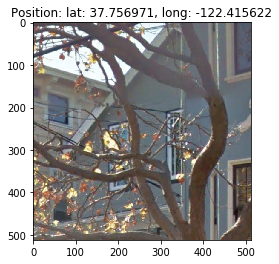

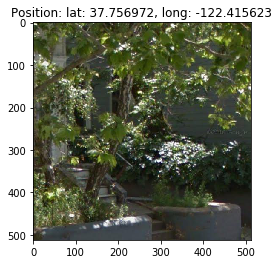

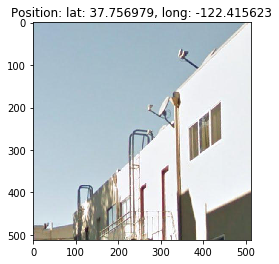

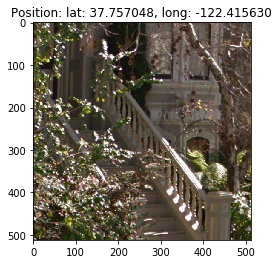

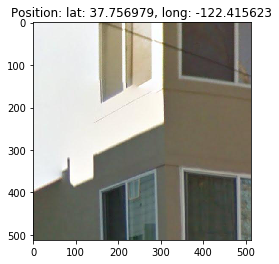

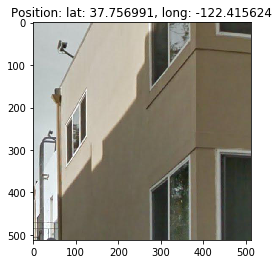

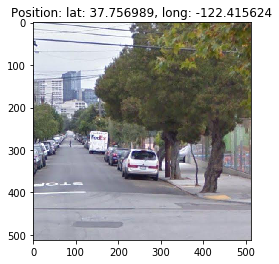

In [20]:
for pos in infered_positives:
    image_path = pos["im_path"]
    sign_pos = "lat: {lat}, long: {lng}".format(
        lat=pos["lat"],
        lng=pos["lng"])
    im = misc.imread(image_path)
    plt.figure()
    plt.title("Position: {}".format(sign_pos))
    plt.imshow(im)